# SALUD MURCIA

Lectura del conjunto de datos obtenido de la pagina de salud de Murcia 
https://www.murciasalud.es/pagina.php?id=458869
Recogidos desde el 08/03/2020 hasta el dia 25/03/2020

In [1]:
from pandas import read_csv
#lectura = read_csv('../Datos_originales/casos_diarios_total_regional.csv', skiprows = 4, encoding='latin-1', sep = ';', index_col = 0, na_values = ['NaN', 'NaT'])
# NEW
lectura = read_csv('../Datos_originales/casos_diarios_total_regional.csv', skiprows = 4, encoding='latin-1', sep = ';', na_values = ['NaN', 'NaT'])

# Headers = columnas de mi conjunto de datos. Si no especificamos asume que son las de la primera fila leida
# Skiprows = n: con n = numero de filas que quiero saltar. Las cuatro primeras son texto -> las saltamos
# Encoding = 'latin-1': para que no de errores de codificacion de algunos caracteres 
# Sep = ';': delimitador que separa las columnas
# Index_col = 0: usar la primera columna (fechas) como filas del dataframe

Renombramos los nombres de algunas de las columnas para que queden mas compactos

In [2]:
datos = lectura.rename(columns={'Pruebas_PCR_Ag':'Pruebas_PCR_Ag',
                                'Casos_incidentes_PCR/Ag+':'Incidentes_PCR_Ag',
                                'Hospitalizados': 'H',
                                'Hospitaliz_UCI':'H_UCI',
                                'Asintomatico_hombre_<45años': 'Asint_H_<45',
                                'Asintomatico_hombre_45a64años': 'Asint_H_45a64',
                                'Asintomatico_hombre_+65años': 'Asint_H_+65',
                                'Sintomatico_hombre_<45años': 'Sint_H_<45',
                                'Sintomatico_hombre_45a64años': 'Sint_H_45a64',
                                'Sintomatico_hombre_+65años': 'Sint_H_+65',
                                'Asintomatico_mujer_<45años': 'Asint_M_<45',
                                'Asintomatico_mujer_45a64años': 'Asint_M_45a64',
                                'Asintomatico_mujer_+65años': 'Asint_M_+65',
                                'Sintomatico_mujer_<45años': 'Sint_M_<45',
                                'Sintomatico_mujer_45a64años': 'Sint_M_45a64',
                                'Sintomatico_mujer_+65años': 'Sint_M_+65'})

In [3]:
import pandas as pd
df_salud_murcia = pd.DataFrame(datos)

In [4]:
df_salud_murcia.head(5)

,Fecha,Pruebas_PCR_Ag,Incidentes_PCR_Ag,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,Sint_H_+65,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65
0,08/03/2020,130.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,09/03/2020,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2,10/03/2020,39.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
3,11/03/2020,116.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,4.0,1.0,1.0
4,12/03/2020,136.0,9.0,4.0,1.0,0.0,3.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


In [5]:
# NEW
format = '%d/%m/%Y'
datetime_fecha = pd.to_datetime(df_salud_murcia['Fecha'], format=format)
df_salud_murcia = df_salud_murcia.drop(['Fecha'], axis=1)
df_salud_murcia.head(5)
df_salud_murcia.insert(0,'Fecha', datetime_fecha)
df_salud_murcia = df_salud_murcia.set_index('Fecha')
df_salud_murcia.head(5)

,Pruebas_PCR_Ag,Incidentes_PCR_Ag,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,Sint_H_+65,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65
Fecha,,,,,,,,,,,,,,,,,
2020-03-08,130.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2020-03-09,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2020-03-10,39.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
2020-03-11,116.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,4.0,1.0,1.0
2020-03-12,136.0,9.0,4.0,1.0,0.0,3.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


Con la siguiente función eliminamos todos aquellos valores que se almacenan o completan como NaN

In [6]:
df_salud_murcia.dropna(axis = 0, inplace = True)

A continuación vamos a coger cada una de las series y para cada una de ellas:
-Eliminación de datos autocompletados de fechas posteriores a la actual
-Visualización de las mismas

## Positivos

In [ ]:
df_positivos = df_salud_murcia['Incidentes_PCR_Ag']
print(df_positivos.head(5))

In [ ]:
df_positivos.size

Fijandonos en las columnas del archivo .csv vemos que hay un total de 382 filas de datos (dias)
Como el tamaño de df_positivos es 495 > 382, podemos sospechar que existen datos de mas
Mostramos las 113 ultimas filas para ver que en efecto existen valores NaN no definidos

In [ ]:
df_positivos.tail(113)

Como podemos observar, hay muchas columnas que tienen datos desconocidos (identificados con NaN)
https://stackabuse.com/python-how-to-handle-missing-dataframe-values-in-pandas/
En este enlace vemos como podemos eliminar las filas cuyos valores son NaN -> mediante la funcion dropna
De esta forma los datos ya se visualizaran solo en las fechas correctas, es decir, las puestas en el .csv

In [ ]:
df_positivos.dropna(axis = 0, inplace = True)

In [ ]:
# Visualización de los datos con un plot simple
from matplotlib import pyplot
df_positivos.plot()
# Rotamos 45º las fechas para que se vean correctamente
pyplot.xticks(rotation=90)
pyplot.show()

Con el siguiente gráfico podemos hacer una primera aproximación sobre la presencia del virus
en la Región de Murcia. A simple vista, la pandemia parece haber sido bien controlada, puesto que
la nube de puntos más densa de encuentra entre los 0 y 500 casos

In [ ]:
from pandas.plotting import lag_plot
lag_plot(df_positivos)
pyplot.show()

## Visualización de todas las series (bucle)

A continuación se realiza un bucle en el que se visualizan los datos de todas las series del dataframe

In [ ]:
from matplotlib import pyplot
for c in df_salud_murcia.columns:
    dfc = df_salud_murcia[c]
    dfc.plot()
    print('Serie: ', c)
    pyplot.xticks(rotation=90)
    pyplot.show()

Las gráficas tienen mucha similitud entre ellas, lo que es bastante lógico.
El aumento/disminución del número de casos positivos se ve directamente relacionado con 
el aumento de hospitalizaciones, defunciones, asintomáticos, sintomáticos,...
En la siguiente tabla se muestra una matriz de correlación numérica y posteriormente de forma
gráfica para ayudarnos en la comprensión

In [ ]:
df.corr()

In [ ]:
matriz_corr = df.corr()
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(matriz_corr, annot=True)
plt.show()

## Sumando asintomáticos
En esta sección vamos a sumar a todos los asintomáticos (por fecha) y añadirlos en una nueva serie
del dataframe a la que llamaré "Asintomaticos"

In [ ]:
df_salud_murcia['Asintomaticos'] = df_salud_murcia['Asint_H_<45'] + df_salud_murcia['Asint_H_45a64'] + df_salud_murcia['Asint_H_+65']

A continuación lo que hacemos es guardarla en un archivo de extensión .csv 

In [ ]:
df_salud_murcia.to_csv(path_or_buf = '../Datos_preprocesados./datos_suma_asintomaticos.csv')

## Añadiendo movilidad
En esta sección añadiremos los datos de movilidad del INE tanto hacia el interior de la región como hacia el exterior.
Tenemos dos carpetas de datos, la primera va desde el 16 de marzo de 2020 hasta el 20 junio de 2020 y la segunda
desde el 24 de junio de 2020 hasta el 31 de diciembre de 2020.

La siguiente función es un "parseador" de fechas en base a los archivos .zip para sacar el día
en el que se recogieron los datos

In [7]:
def parseador_fechas(nombre):
    # Cogemos el día
    dia = nombre[4:6]
    mes = nombre[6:9]
    anio = nombre[10:14]
    if mes == 'MAR':
        mes = '03'
    if mes == 'ABR':
        mes = '04'
    if mes == 'MAY':
        mes = '05'
    if mes == 'JUN':
        mes = '06'
    return(anio+'-'+dia+'-'+mes)

In [8]:
import os
import zipfile
import pandas as pd

ruta = '../Datos_originales/mar-jun/'

lista_entradas = []
lista_salidas = []
lista_fechas = []

# Cogemos los archivos .zip diarios
archivos = os.listdir(ruta)

# SALIDAS DE LA REGION
# Iteramos sobre cada uno de estos
for a in archivos:
    # Los leemos con zipfile
    z = zipfile.ZipFile(ruta+a, 'r')
    # Iteramos en cada uno de los ficheros del zip
    for az in z.namelist():
        # Cogemos los .csv que nos interesan
        if "PobxCeldasOrigen" in az:
            # Nos quedamos con el dia
            fecha = parseador_fechas(az)
            lista_fechas.append(fecha)
            # Como son archivos .csv leemos
            from pandas import read_csv
            df_f = pd.read_csv(z.open(az), sep=';', encoding = 'latin-1')
            #print(df.columns)
            df_murcia = df_f[df_f['NOMBRE_CELDA_ORIGEN '].str.contains("Murcia \(")]
            suma_salidas_murcia = df_murcia['POB_SALE '].sum()
            lista_salidas.append(suma_salidas_murcia)
            
        if "PobxCeldasDestino" in az:
            # Como son archivos .csv leemos
            from pandas import read_csv
            df_f = pd.read_csv(z.open(az), sep=';', encoding = 'latin-1')
            #print(df.columns)
            df_murcia = df_f[df_f['NOMBRE_CELDA_DESTINO '].str.contains("Murcia \(")]
            suma_salidas_murcia = df_murcia['POB_LLEGA '].sum()
            lista_entradas.append(suma_salidas_murcia)

In [ ]:
#df_entradas_salidas = pd.DataFrame(list(zip(lista_entradas, lista_salidas)), columns =['Entradas', 'Salidas'], index = lista_fechas)
#df_entradas_salidas.index.name = 'Fecha'
#df_entradas_salidas.head(5)

In [9]:
# NEW
# convierto las fechas en DatatimeIndex
format = '%Y-%d-%m'
fechas_serie = pd.to_datetime(lista_fechas, format=format)
df_entradas_salidas = pd.DataFrame(list(zip(lista_entradas, lista_salidas)), columns =['Entradas', 'Salidas'])
df_entradas_salidas.insert(0,'Fecha', fechas_serie)
df_entradas_salidas = df_entradas_salidas.set_index('Fecha')
df_entradas_salidas['month'] = fechas_serie.month
df_entradas_salidas['year'] = fechas_serie.year
df_entradas_salidas['day'] = fechas_serie.day
df_entradas_salidas = df_entradas_salidas.sort_values(['month','day','year']).drop(columns=['day', 'month', 'year'])
df_entradas_salidas.head(5)

,Entradas,Salidas
Fecha,,
2020-03-16,73462,73898
2020-03-18,68851,69944
2020-03-20,62417,62512
2020-03-22,34006,34575
2020-03-24,66884,66296


Lo siguiente que hacemos es guardar este nuevo data frame en la carpeta de datos procesados

In [10]:
df_entradas_salidas.to_csv(path_or_buf = '../Datos_preprocesados./datos_entradas_salidas_murcia.csv')

In [11]:
df_salud_murcia.head(5)

,Pruebas_PCR_Ag,Incidentes_PCR_Ag,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,Sint_H_+65,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65
Fecha,,,,,,,,,,,,,,,,,
2020-03-08,130.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2020-03-09,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2020-03-10,39.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
2020-03-11,116.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,4.0,1.0,1.0
2020-03-12,136.0,9.0,4.0,1.0,0.0,3.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


In [12]:
df_entradas_salidas.head(5)

,Entradas,Salidas
Fecha,,
2020-03-16,73462,73898
2020-03-18,68851,69944
2020-03-20,62417,62512
2020-03-22,34006,34575
2020-03-24,66884,66296


In [13]:
import pandas
df_final = pandas.concat([df_salud_murcia, df_entradas_salidas], axis=1)
df_final.to_csv(path_or_buf = '../Datos_preprocesados./datos_murcia_mas_entradas_salidas.csv')

In [14]:
df_final.head(15)

,Pruebas_PCR_Ag,Incidentes_PCR_Ag,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,Sint_H_+65,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65,Entradas,Salidas
Fecha,,,,,,,,,,,,,,,,,,,
2020-03-08,130.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN
2020-03-09,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,NaN,NaN
2020-03-10,39.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN
2020-03-11,116.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,4.0,1.0,1.0,NaN,NaN
2020-03-12,136.0,9.0,4.0,1.0,0.0,3.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN
2020-03-13,228.0,12.0,8.0,1.0,0.0,1.0,1.0,0.0,2.0,3.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN
2020-03-14,196.0,23.0,8.0,2.0,0.0,1.0,2.0,0.0,3.0,2.0,4.0,1.0,0.0,1.0,3.0,6.0,1.0,NaN,NaN
2020-03-15,121.0,18.0,13.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,1.0,1.0,1.0,6.0,2.0,1.0,NaN,NaN
2020-03-16,147.0,24.0,18.0,3.0,0.0,1.0,1.0,0.0,4.0,2.0,2.0,3.0,0.0,0.0,3.0,3.0,0.0,73462.0,73898.0


Mostramos las entradas a la Región de Murcia ignorando los valores NaN no existentes

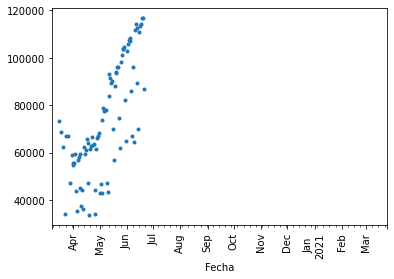

In [15]:
from matplotlib import pyplot
import numpy as np
s_entradas = df_final['Entradas']
#s_entradas.dropna(axis = 0, inplace = True)
#o = s_entradas.replace({np.nan: None})
s_entradas.plot(style = '.')
pyplot.xticks(rotation=90)
pyplot.show()